In [ ]:
# Experiment 1: Fine-tuning BERT-base-uncased on English Sentiment Dataset
# This notebook implements the training procedure for the first experiment in our cross-lingual sentiment analysis project

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader

In [ ]:
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)

In [ ]:
import os
import random
import re
!pip install emoji
import emoji
from tqdm.notebook import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.4 MB/s eta 0:00:00


In [ ]:
# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [ ]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# ## 1. Data Preparation

# Function to clean and normalize text
def clean_text(text, is_pidgin=False):
    """
    Clean and normalize text data

    Args:
        text (str): Input text
        is_pidgin (bool): Whether the text is Nigerian Pidgin

    Returns:
        str: Cleaned text
    """
    if not isinstance(text, str):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' [URL] ', text)

    # Remove user mentions (@username)
    text = re.sub(r'@\w+', ' [USER] ', text)

    # Handle hashtags - keep the text but remove the # symbol
    text = re.sub(r'#(\w+)', r'\1', text)

    # Convert emojis to text (alternatively, you can remove them)
    text = emoji.demojize(text)
    text = re.sub(r':[a-z_]+:', ' [EMOJI] ', text)  # replace with token or remove

    # Remove special characters but keep apostrophes (important for contractions)
    text = re.sub(r'[^a-zA-Z0-9\'\s]', ' ', text)

    # Normalize apostrophes
    text = text.replace("'", "'")

    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)

    # For Pidgin-specific normalization
    if is_pidgin:
        # Define common Pidgin expressions to preserve
        pidgin_normalizations = {
            # Common variations
            " de ": " dey ",
            " sey ": " say ",
            " dem ": " them ",
            " una ": " you ",
            " dis ": " this ",
            " dat ": " that ",
            # Common expressions (keep intact)
            "abeg": "abeg",  # please
            "wetin": "wetin",  # what
            "na ": "na ",  # is/it is
            "abi": "abi",  # right?/isn't it?
            "shey": "shey",  # is it that
            "sha": "sha",  # anyway/though
            "wahala": "wahala",  # trouble
            "japa": "japa",  # run away/leave
            "gats": "gats",  # must/have to
        }

        for old, new in pidgin_normalizations.items():
            text = text.replace(old, new)

    return text.strip()


In [ ]:
# Custom dataset class
class SentimentDataset(Dataset):
    """PyTorch dataset for sentiment analysis"""
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Remove the batch dimension which tokenizer adds by default
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding['labels'] = torch.tensor(label)

        return encoding

In [ ]:
# Load and prepare datasets
print("Loading datasets...")

Loading datasets...


In [ ]:
# Load English dataset
english_df = pd.read_csv('English_dataset.csv')
print(f"English dataset shape: {english_df.shape}")

English dataset shape: (10000, 2)


In [ ]:
# Map sentiments to numeric values
sentiment_map = {'positive': 0, 'negative': 1, 'neutral': 2}
english_df['label'] = english_df['Sentiments'].map(sentiment_map)

In [ ]:
# Check sentiment distribution
sentiment_counts = english_df['Sentiments'].value_counts()
print("\nSentiment distribution:")
print(sentiment_counts)
print(f"Percentages: {sentiment_counts / len(english_df) * 100}")


Sentiment distribution:
Sentiments
positive    7663
negative    2317
neutral       20
Name: count, dtype: int64
Percentages: Sentiments
positive    76.63
negative    23.17
neutral      0.20
Name: count, dtype: float64


In [ ]:
# Clean text
english_df['cleaned_text'] = english_df['text'].apply(lambda x: clean_text(x, is_pidgin=False))

In [ ]:
# Load Pidgin dataset for testing
pidgin_df = pd.read_csv('new_annotated_pidgin.csv')
print(f"\nPidgin dataset shape: {pidgin_df.shape}")
pidgin_df['label'] = pidgin_df['sentiments'].map(sentiment_map)
pidgin_df['cleaned_text'] = pidgin_df['Comments'].apply(lambda x: clean_text(x, is_pidgin=True))


Pidgin dataset shape: (5000, 2)


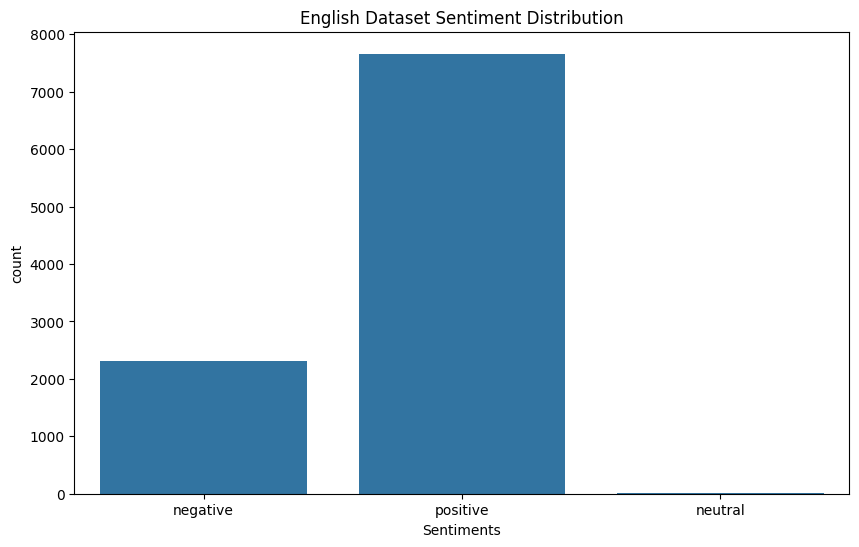

In [ ]:
# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiments', data=english_df)
plt.title('English Dataset Sentiment Distribution')
plt.show()

In [ ]:
# ## 2. Split Datasets

from sklearn.model_selection import train_test_split

# Split into train, validation, and test sets
def split_dataset(df, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Split dataset into train, validation, and test sets with stratification
    """
    # First split: train + validation and test
    train_val, test = train_test_split(
        df, test_size=test_size, random_state=random_state, stratify=df['label']
    )

    # Second split: train and validation
    # Adjust validation size relative to train_val
    relative_val_size = val_size / (train_size + val_size)
    train, val = train_test_split(
        train_val, test_size=relative_val_size, random_state=random_state,
        stratify=train_val['label']
    )

    return train, val, test

In [ ]:
# Split English dataset
english_train, english_val, english_test = split_dataset(english_df)

In [ ]:
# Display split sizes
print("\nDataset splits:")
print(f"English - Train: {len(english_train)}, Val: {len(english_val)}, Test: {len(english_test)}")


Dataset splits:
English - Train: 7000, Val: 1500, Test: 1500


In [ ]:
# Check class distribution in splits
print("\nTrain distribution:")
print(english_train['Sentiments'].value_counts())
print("\nValidation distribution:")
print(english_val['Sentiments'].value_counts())
print("\nTest distribution:")
print(english_test['Sentiments'].value_counts())


Train distribution:
Sentiments
positive    5364
negative    1622
neutral       14
Name: count, dtype: int64

Validation distribution:
Sentiments
positive    1150
negative     347
neutral        3
Name: count, dtype: int64

Test distribution:
Sentiments
positive    1149
negative     348
neutral        3
Name: count, dtype: int64


In [ ]:
# Sample pidgin test data
pidgin_test = pidgin_df.sample(750, random_state=42)  # As specified in experiment design
print(f"\nPidgin test set size: {len(pidgin_test)}")
print("Pidgin test distribution:")
print(pidgin_test['sentiments'].value_counts())


Pidgin test set size: 750
Pidgin test distribution:
sentiments
negative    469
neutral     203
positive     78
Name: count, dtype: int64


In [ ]:
# ## 3. Initialize Tokenizer

# Initialize and enhance BERT tokenizer for better Pidgin handling
def enhance_tokenizer_for_pidgin(tokenizer):
    """Enhance tokenizer with Nigerian Pidgin specific tokens"""
    # Common Pidgin expressions to add as special tokens
    pidgin_special_tokens = {
        'additional_special_tokens': [
            '[ABEG]', '[WETIN]', '[DEY]', '[NA]', '[SHEY]', '[ABI]',
            '[WAHALA]', '[SHA]', '[SABI]', '[JAPA]', '[GATS]'
        ]
    }

    # Add special tokens
    num_added = tokenizer.add_special_tokens(pidgin_special_tokens)
    print(f"Added {num_added} special tokens to tokenizer")

    return tokenizer

In [ ]:
# Initialize the tokenizer
print("Initializing tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = enhance_tokenizer_for_pidgin(tokenizer)

Initializing tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Added 11 special tokens to tokenizer


In [ ]:
# Determine optimal sequence length
def analyze_token_lengths(texts, tokenizer, percentile=95):
    """Analyze token length distribution and determine max length"""
    token_lengths = []
    for text in tqdm(texts, desc="Analyzing token lengths"):
        if isinstance(text, str) and text.strip():
            tokens = tokenizer.tokenize(text)
            token_lengths.append(len(tokens))

    # Calculate statistics
    mean_len = np.mean(token_lengths)
    median_len = np.median(token_lengths)
    p95 = np.percentile(token_lengths, percentile)
    max_len = np.max(token_lengths)

    # Round up to nearest multiple of 8 for efficiency
    recommended_length = ((int(p95) + 7) // 8) * 8

    print(f"Token length statistics:")
    print(f"Mean: {mean_len:.1f}")
    print(f"Median: {median_len:.1f}")
    print(f"95th percentile: {p95:.1f}")
    print(f"Max: {max_len}")
    print(f"Recommended max_length: {recommended_length}")

    return recommended_length, token_lengths

In [ ]:
# Analyze English and Pidgin token lengths
print("\nAnalyzing English token lengths...")
english_sample = english_df['cleaned_text'].sample(500, random_state=42).tolist()
max_length_english, english_lengths = analyze_token_lengths(english_sample, tokenizer)

print("\nAnalyzing Pidgin token lengths...")
pidgin_sample = pidgin_df['cleaned_text'].sample(500, random_state=42).tolist()
max_length_pidgin, pidgin_lengths = analyze_token_lengths(pidgin_sample, tokenizer)


Analyzing English token lengths...


Analyzing token lengths:   0%|          | 0/500 [00:00<?, ?it/s]

Token length statistics:
Mean: 38.4
Median: 22.0
95th percentile: 126.3
Max: 819
Recommended max_length: 128

Analyzing Pidgin token lengths...


Analyzing token lengths:   0%|          | 0/500 [00:00<?, ?it/s]

Token length statistics:
Mean: 51.1
Median: 31.0
95th percentile: 161.2
Max: 929
Recommended max_length: 168


In [ ]:
# Use the maximum of both for test data to handle both languages
max_length_test = max(max_length_english, max_length_pidgin)

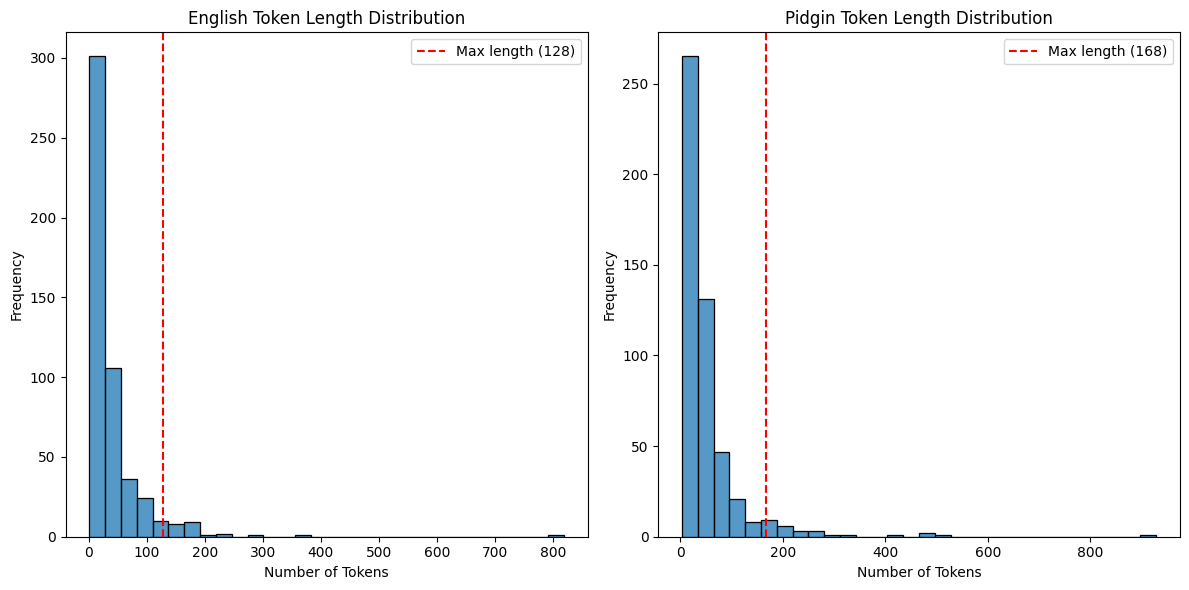

In [ ]:
# Visualize token length distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(english_lengths, bins=30)
plt.axvline(x=max_length_english, color='r', linestyle='--', label=f'Max length ({max_length_english})')
plt.title('English Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(pidgin_lengths, bins=30)
plt.axvline(x=max_length_pidgin, color='r', linestyle='--', label=f'Max length ({max_length_pidgin})')
plt.title('Pidgin Token Length Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# ## 4. Create PyTorch Datasets

# Prepare datasets
print("Creating PyTorch datasets...")

# Training dataset
train_dataset = SentimentDataset(
    english_train['cleaned_text'].tolist(),
    english_train['label'].tolist(),
    tokenizer,
    max_length=max_length_english
)

# Validation dataset
val_dataset = SentimentDataset(
    english_val['cleaned_text'].tolist(),
    english_val['label'].tolist(),
    tokenizer,
    max_length=max_length_english
)

# Test datasets (separate for English and Pidgin for cross-lingual evaluation)
english_test_dataset = SentimentDataset(
    english_test['cleaned_text'].tolist(),
    english_test['label'].tolist(),
    tokenizer,
    max_length=max_length_test  # Use longer sequence length for test
)

pidgin_test_dataset = SentimentDataset(
    pidgin_test['cleaned_text'].tolist(),
    pidgin_test['label'].tolist(),
    tokenizer,
    max_length=max_length_test  # Use longer sequence length for test
)


Creating PyTorch datasets...


In [ ]:
# Combined test dataset
combined_test_texts = english_test['cleaned_text'].tolist() + pidgin_test['cleaned_text'].tolist()
combined_test_labels = english_test['label'].tolist() + pidgin_test['label'].tolist()

combined_test_dataset = SentimentDataset(
    combined_test_texts,
    combined_test_labels,
    tokenizer,
    max_length=max_length_test
)

In [ ]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"English test dataset size: {len(english_test_dataset)}")
print(f"Pidgin test dataset size: {len(pidgin_test_dataset)}")
print(f"Combined test dataset size: {len(combined_test_dataset)}")

# Check example batch
train_batch = next(iter(DataLoader(train_dataset, batch_size=2)))
print("\nExample batch keys:", train_batch.keys())
print(f"Input IDs shape: {train_batch['input_ids'].shape}")
print(f"Attention mask shape: {train_batch['attention_mask'].shape}")
print(f"Labels: {train_batch['labels']}")


Train dataset size: 7000
Validation dataset size: 1500
English test dataset size: 1500
Pidgin test dataset size: 750
Combined test dataset size: 2250

Example batch keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
Input IDs shape: torch.Size([2, 128])
Attention mask shape: torch.Size([2, 128])
Labels: tensor([0, 0])


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [ ]:
# ## 5. Model Setup and Training

# Define metrics function
def compute_metrics(pred):
    """Compute metrics for evaluation"""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize model
print("\nInitializing model...")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,  # positive, negative, neutral
)



Initializing model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Resize token embeddings to account for new tokens
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(30533, 768, padding_idx=0)

In [ ]:
# Training arguments
print("\nSetting up training arguments...")
training_args = TrainingArguments(
    output_dir="./results/exp1",
    num_train_epochs=5,
    per_device_train_batch_size=16,  # Adjust based on GPU memory
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs/exp1",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    push_to_hub=False,
)

# Initialize Trainer with early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).



Setting up training arguments...


In [ ]:
# ## 6. Train Model

# Train the model
print("\nTraining the model...")
trainer.train()


Training the model...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.228100,0.235547,0.934000,0.930769,0.932287,0.934000
2,0.166100,0.198500,0.946667,0.946087,0.945733,0.946667
3,0.067100,0.243461,0.946000,0.943718,0.944141,0.946000
4,0.037200,0.244130,0.952000,0.951661,0.951552,0.952000
5,0.018800,0.259495,0.953333,0.953241,0.953168,0.953333


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=2190, training_loss=0.13035552000890585, metrics={'train_runtime': 851.2647, 'train_samples_per_second': 41.115, 'train_steps_per_second': 2.573, 'total_flos': 2302242405120000.0, 'train_loss': 0.13035552000890585, 'epoch': 5.0})

In [ ]:
# Save the final model
print("\nSaving the best model...")
trainer.save_model("./results/exp1/best_model")
tokenizer.save_pretrained("./results/exp1/tokenizer")



Saving the best model...


('./results/exp1/tokenizer/tokenizer_config.json',
 './results/exp1/tokenizer/special_tokens_map.json',
 './results/exp1/tokenizer/vocab.txt',
 './results/exp1/tokenizer/added_tokens.json')

In [ ]:
!zip -r /content/exp1_model.zip /content/results/exp1


  adding: content/results/exp1/ (stored 0%)
  adding: content/results/exp1/checkpoint-438/ (stored 0%)
  adding: content/results/exp1/checkpoint-438/training_args.bin (deflated 52%)
  adding: content/results/exp1/checkpoint-438/trainer_state.json (deflated 64%)
  adding: content/results/exp1/checkpoint-438/rng_state.pth (deflated 25%)
  adding: content/results/exp1/checkpoint-438/scheduler.pt (deflated 55%)
  adding: content/results/exp1/checkpoint-438/optimizer.pt (deflated 22%)
  adding: content/results/exp1/checkpoint-438/config.json (deflated 51%)
  adding: content/results/exp1/checkpoint-438/model.safetensors (deflated 7%)
  adding: content/results/exp1/checkpoint-1752/ (stored 0%)
  adding: content/results/exp1/checkpoint-1752/training_args.bin (deflated 52%)
  adding: content/results/exp1/checkpoint-1752/trainer_state.json (deflated 73%)
  adding: content/results/exp1/checkpoint-1752/rng_state.pth (deflated 25%)
  adding: content/results/exp1/checkpoint-1752/scheduler.pt (deflat

In [ ]:
# ## 7. Evaluation

# Evaluate on validation set
print("\nEvaluating on validation set...")
val_results = trainer.evaluate(val_dataset)
print(f"Validation results: {val_results}")

# Evaluate on English test set
print("\nEvaluating on English test set...")
english_test_results = trainer.evaluate(english_test_dataset)
print(f"English test results: {english_test_results}")

# Evaluate on Pidgin test set
print("\nEvaluating on Pidgin test set (cross-lingual performance)...")
pidgin_test_results = trainer.evaluate(pidgin_test_dataset)
print(f"Pidgin test results: {pidgin_test_results}")

# Evaluate on combined test set
print("\nEvaluating on combined test set...")
combined_test_results = trainer.evaluate(combined_test_dataset)
print(f"Combined test results: {combined_test_results}")


Evaluating on validation set...


Validation results: {'eval_loss': 0.2594946026802063, 'eval_accuracy': 0.9533333333333334, 'eval_f1': 0.9532412842190017, 'eval_precision': 0.953167737013102, 'eval_recall': 0.9533333333333334, 'eval_runtime': 11.6185, 'eval_samples_per_second': 129.104, 'eval_steps_per_second': 2.066, 'epoch': 5.0}

Evaluating on English test set...
English test results: {'eval_loss': 0.20535697042942047, 'eval_accuracy': 0.9693333333333334, 'eval_f1': 0.9686529643437483, 'eval_precision': 0.9679807488882985, 'eval_recall': 0.9693333333333334, 'eval_runtime': 16.252, 'eval_samples_per_second': 92.296, 'eval_steps_per_second': 1.477, 'epoch': 5.0}

Evaluating on Pidgin test set (cross-lingual performance)...
Pidgin test results: {'eval_loss': 2.6151723861694336, 'eval_accuracy': 0.5493333333333333, 'eval_f1': 0.5388800041566, 'eval_precision': 0.653384894398139, 'eval_recall': 0.5493333333333333, 'eval_runtime': 7.9355, 'eval_samples_per_second': 94.512, 'eval_steps_per_second': 1.512, 'epoch': 5.0}

E

In [ ]:
# ## 8. Detailed Performance Analysis

# Get predictions for the test sets
def get_predictions(model, dataset, device):
    """Get model predictions for a dataset"""
    dataloader = DataLoader(dataset, batch_size=16)
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting predictions"):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**{k: v for k, v in batch.items() if k != 'labels'})

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [ ]:
# Get predictions
english_preds, english_labels = get_predictions(model, english_test_dataset, device)
pidgin_preds, pidgin_labels = get_predictions(model, pidgin_test_dataset, device)

Getting predictions:   0%|          | 0/94 [00:00<?, ?it/s]

Getting predictions:   0%|          | 0/47 [00:00<?, ?it/s]

In [ ]:
# Detailed metrics
def print_detailed_metrics(preds, labels, dataset_name):
    """Print detailed metrics for a dataset"""
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    print(f"\n{dataset_name} Detailed Metrics:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")

    # Classification report
    label_names = ['positive', 'negative', 'neutral']
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=label_names))

    # Confusion matrix
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


English Test Detailed Metrics:
Accuracy: 0.9693
F1 Score (weighted): 0.9687
Precision (weighted): 0.9680
Recall (weighted): 0.9693

Classification Report:
              precision    recall  f1-score   support

    positive       0.98      0.98      0.98      1149
    negative       0.94      0.94      0.94       348
     neutral       0.00      0.00      0.00         3

    accuracy                           0.97      1500
   macro avg       0.64      0.64      0.64      1500
weighted avg       0.97      0.97      0.97      1500



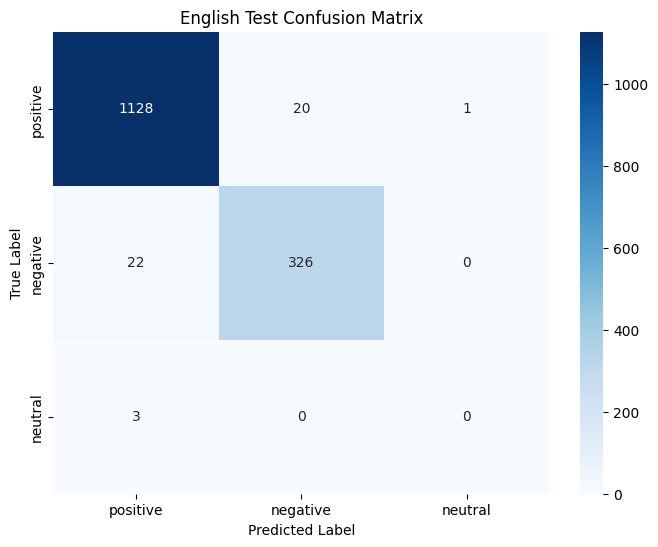


Pidgin Test (Cross-lingual) Detailed Metrics:
Accuracy: 0.5493
F1 Score (weighted): 0.5389
Precision (weighted): 0.6534
Recall (weighted): 0.5493

Classification Report:
              precision    recall  f1-score   support

    positive       0.18      0.56      0.27        78
    negative       0.75      0.74      0.74       469
     neutral       0.62      0.10      0.17       203

    accuracy                           0.55       750
   macro avg       0.52      0.47      0.39       750
weighted avg       0.65      0.55      0.54       750



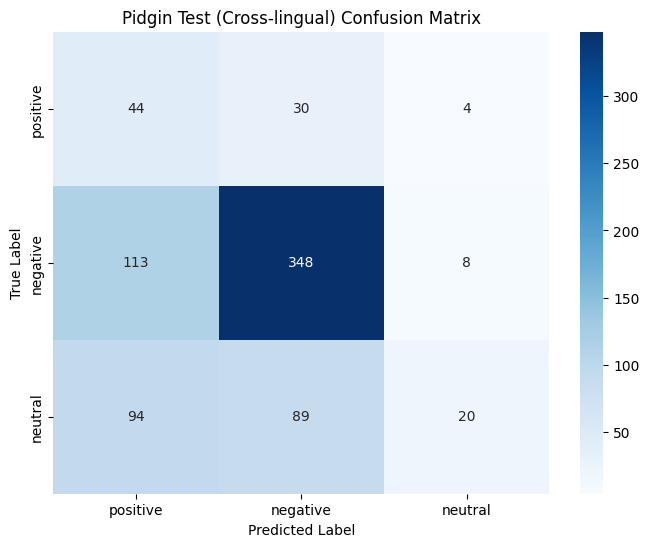

In [ ]:
# Print detailed metrics
print_detailed_metrics(english_preds, english_labels, "English Test")
print_detailed_metrics(pidgin_preds, pidgin_labels, "Pidgin Test (Cross-lingual)")


In [ ]:
# ## 9. Analyze Error Cases

# Function to analyze error cases
def analyze_errors(texts, preds, labels, dataset_name, max_examples=10):
    """Analyze and display error cases"""
    errors = []
    for i in range(len(texts)):
        if preds[i] != labels[i]:
            errors.append({
                'text': texts[i],
                'true_label': labels[i],
                'pred_label': preds[i]
            })

    print(f"\n{dataset_name} Error Analysis ({len(errors)} errors out of {len(texts)} samples):")
    print(f"Error rate: {len(errors)/len(texts):.2%}")

    # Group errors by type
    error_types = {}
    for error in errors:
        key = f"{error['true_label']} -> {error['pred_label']}"
        if key not in error_types:
            error_types[key] = []
        error_types[key].append(error)

    # Print error distribution
    print("\nError distribution:")
    for error_type, examples in error_types.items():
        true_label, pred_label = error_type.split(' -> ')
        label_map_inv = {0: 'positive', 1: 'negative', 2: 'neutral'}
        true_name = label_map_inv[int(true_label)]
        pred_name = label_map_inv[int(pred_label)]
        print(f"  {true_name} predicted as {pred_name}: {len(examples)} cases ({len(examples)/len(errors):.2%} of errors)")

    # Show examples of each error type
    print("\nExample errors by type:")
    for error_type, examples in error_types.items():
        true_label, pred_label = error_type.split(' -> ')
        label_map_inv = {0: 'positive', 1: 'negative', 2: 'neutral'}
        true_name = label_map_inv[int(true_label)]
        pred_name = label_map_inv[int(pred_label)]

        print(f"\n{true_name} predicted as {pred_name}:")
        for i, error in enumerate(examples[:max_examples]):
            print(f"  Example {i+1}: {error['text']}")

In [ ]:
# Analyze English errors
analyze_errors(
    english_test['cleaned_text'].tolist(),
    english_preds,
    english_labels,
    "English Test"
)



English Test Error Analysis (46 errors out of 1500 samples):
Error rate: 3.07%

Error distribution:
  negative predicted as positive: 22 cases (47.83% of errors)
  positive predicted as negative: 20 cases (43.48% of errors)
  neutral predicted as positive: 3 cases (6.52% of errors)
  positive predicted as neutral: 1 cases (2.17% of errors)

Example errors by type:

negative predicted as positive:
  Example 1: this is my go to coffee i love the flavor the price is reasonable for how many k cups you get definitely recommend it
  Example 2: very good ristretto but you only get a fraction out of your investment the way the capsules are designed the problem they do not allow to release the pressure at the right moment coffee comes out of the top and spills all over your dolce gusto coffee makers i have three different coffee makers and they don t work with any of them all original nes caf capsules work it s no problem be careful buying other than original
  Example 3: sorry to say this tea

In [ ]:
# Analyze Pidgin errors
analyze_errors(
    pidgin_test['cleaned_text'].tolist(),
    pidgin_preds,
    pidgin_labels,
    "Pidgin Test"
)



Pidgin Test Error Analysis (338 errors out of 750 samples):
Error rate: 45.07%

Error distribution:
  neutral predicted as negative: 89 cases (26.33% of errors)
  positive predicted as negative: 30 cases (8.88% of errors)
  neutral predicted as positive: 94 cases (27.81% of errors)
  negative predicted as positive: 113 cases (33.43% of errors)
  negative predicted as neutral: 8 cases (2.37% of errors)
  positive predicted as neutral: 4 cases (1.18% of errors)

Example errors by type:

neutral predicted as negative:
  Example 1: all these thingsna on top radio we dey hear am we nor kuku dey see amabi na niger Niger i dey wey i dey hear nigeria Nigeria news EMOJI why is everything to help the poor under this administration audio while the one for the rich dey hit their account before it's even announced as token is buhari not better like this at least with him i saw people who benefited from npower tradermoni and school feeding till he handed it over to his gf niger ia which way
  Examp

In [ ]:
# ## 10. Compare Performance Across Languages

# Comparison chart
def plot_performance_comparison(english_metrics, pidgin_metrics):
    """Plot performance comparison between languages"""
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    english_scores = [english_metrics[f'eval_{m}'] for m in metrics]
    pidgin_scores = [pidgin_metrics[f'eval_{m}'] for m in metrics]

    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, english_scores, width, label='English')
    rects2 = ax.bar(x + width/2, pidgin_scores, width, label='Pidgin (Cross-lingual)')

    ax.set_ylabel('Score')
    ax.set_title('Performance Comparison: English vs. Pidgin')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Add value labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()


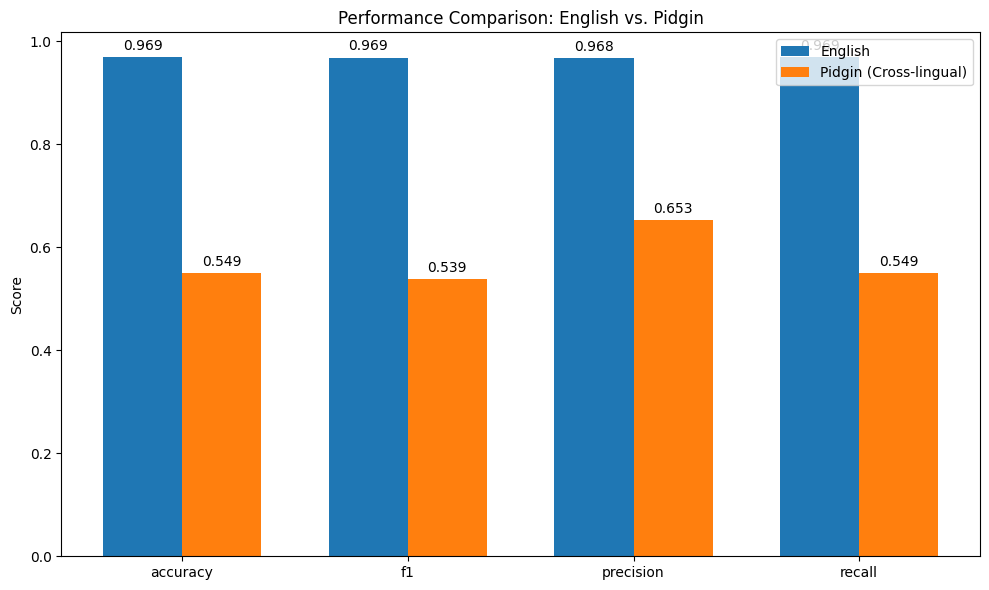

In [ ]:
# Plot performance comparison
plot_performance_comparison(english_test_results, pidgin_test_results)

In [ ]:
# ## 11. Save Results and Summary

# Create output directory if it doesn't exist
os.makedirs("./results/exp1", exist_ok=True)

# Save all results
results_summary = {
    'validation': val_results,
    'english_test': english_test_results,
    'pidgin_test': pidgin_test_results,
    'combined_test': combined_test_results
}

# Write results to file
with open("./results/exp1/results_summary.txt", "w") as f:
    f.write("Experiment 1: BERT-base-uncased fine-tuned on English\n")
    f.write("=============================================\n\n")

    f.write("Model: bert-base-uncased\n")
    f.write(f"Train dataset size: {len(train_dataset)}\n")
    f.write(f"Validation dataset size: {len(val_dataset)}\n")
    f.write(f"English test dataset size: {len(english_test_dataset)}\n")
    f.write(f"Pidgin test dataset size: {len(pidgin_test_dataset)}\n")
    f.write(f"Combined test dataset size: {len(combined_test_dataset)}\n\n")

    f.write("Results:\n")
    for dataset_name, results in results_summary.items():
        f.write(f"\n{dataset_name.upper()} RESULTS:\n")
        for metric, value in results.items():
            f.write(f"  {metric}: {value}\n")

print("\nExperiment completed! Results saved to ./results/exp1/results_summary.txt")


Experiment completed! Results saved to ./results/exp1/results_summary.txt
